DATASET 1 - ADULT
QUESTION 1

In [1]:
!pip install 'aif360'
#Code to install the aif360 library if not already on device 

In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-12 16:13:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  3.59MB/s    in 1.1s    

2022-05-12 16:13:34 (3.59 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-12 16:13:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

In [4]:
pip install fairlearn

In [5]:
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
import numpy as np
from sklearn.preprocessing import StandardScaler
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import StratifiedKFold

np.random.seed(4) #set random seed for reproducible results

In [6]:
OG_dataset = load_preproc_data_adult(['sex']) #setting the protected attribute to sex

OG_dataset_train, OG_dataset_test = OG_dataset.split([0.7], shuffle=True) #Split the dataset, 70% for training and 30% for test

privileged_groups = [{'sex': 1}] #Male
unprivileged_groups = [{'sex': 0}] #Female

#Normalise the data (as per the lab class)
scale = StandardScaler()
X_train = scale.fit_transform(OG_dataset_train.features) #scales each feature/variable to unit variance
y_train = OG_dataset_train.labels.ravel() #Flattens array

X_test = scale.transform(OG_dataset_test.features) 
y_test = OG_dataset_test.labels.ravel() 



Text(0.5, 0, 'Female                                             Male')

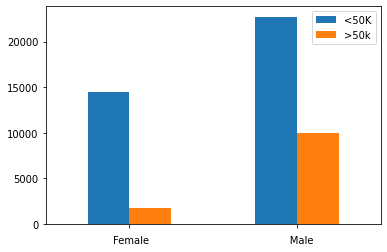

In [7]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

df = pd.DataFrame( OG_dataset.features , columns= OG_dataset.feature_names) #pandas dataframe makes visualisaion easier
df = df.assign(labels=OG_dataset.labels)

crosstab = pd.crosstab(df['sex'], df['labels'])

#bar chart to visualise the data we have
ax = crosstab.plot(kind='bar')
ax.legend(["<50K", ">50k"])
ax.xaxis.set_ticklabels([]) 
ax.set_xlabel("Female                                             Male")

In [8]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

In [9]:
Cross_Validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) #defining number of folds for cross validation
Model = LogisticRegression(solver='liblinear', random_state=1) #defining my model

Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation) #training my cross validated models

print('Accuracy: %.3f  Standard deviation: %.3f' % (mean(Scores), std(Scores))) #printing the accuracy + SD

Accuracy: 0.804  Standard deviation: 0.004


In [10]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001] #the regularisation values i will be using for my analysis

my_dict = {}
accuracy = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation) #performing cross validation and outputting average accuracy
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)))
  accuracy.append(mean(Scores))

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict, key=my_dict.get) #selecting the C value pertaining to the most accurate model, stores in a dictionary for easy look up

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

C value = 100000  Accuracy: 0.804
C value = 1000  Accuracy: 0.804
C value = 10  Accuracy: 0.804
C value = 1.0  Accuracy: 0.804
C value = 0.01  Accuracy: 0.805
C value = 0.0001  Accuracy: 0.798
C value = 1e-06  Accuracy: 0.796
C value = 1e-08  Accuracy: 0.796
The model with the highest accuracy has a C value of:  0.01


In [11]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
fairness = []
value= 0

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation) #performing cross validations and outputting predictions

  train_predictions = OG_dataset_train.copy() #copy of train dataset
  train_predictions.labels = predictions #adding the predictions just made to the copy of the dataset 

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference() #applying equality of opportunity metric to predictions based on groups defined earlier 
  print("C value = " +  str(i) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)
  fairness.append(Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict.items(), key=lambda x: abs(value - x[1])) #selecting the value closest to 0 from a dictionary 

print( "The model with the highest fairness has a C value of: ", fair_key)

C value = 100000  Equality_of_Opportunity score: -0.452
C value = 1000  Equality_of_Opportunity score: -0.452
C value = 10  Equality_of_Opportunity score: -0.452
C value = 1.0  Equality_of_Opportunity score: -0.452
C value = 0.01  Equality_of_Opportunity score: -0.449
C value = 0.0001  Equality_of_Opportunity score: -0.240
C value = 1e-06  Equality_of_Opportunity score: -0.231
C value = 1e-08  Equality_of_Opportunity score: -0.224
The model with the highest fairness has a C value of:  1e-08


In [12]:
Model_1 = find_best_accuracy
Model_2 = fair_key

In [13]:
from sklearn.model_selection import cross_validate

In [14]:
print("C value = ", Model_1)
Model = LogisticRegression(C=Model_1, solver='liblinear')
Model.fit(X_train, y_train) #fitting more accurate model
predictions = Model.predict(X_test) #making predictions

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference() #applying eqaulity of opportunity metric
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.01
Accuracy 0.8027025182556473
Equality_of_Opportunity score: -0.451


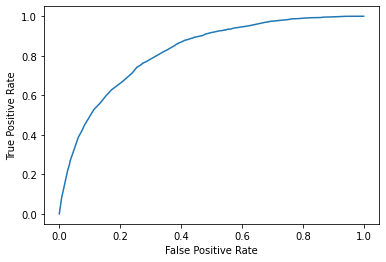

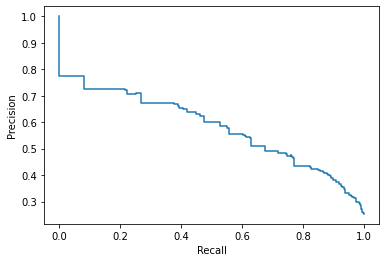

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

#plotting ROC curves and precision recall curves - code adapted from Scikit learn[16]

In [16]:
print("C value = ", Model_2)
Model = LogisticRegression(C=Model_2, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1e-08
Accuracy 0.7963556950795059
Equality_of_Opportunity score: -0.231


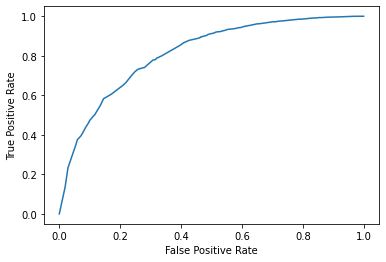

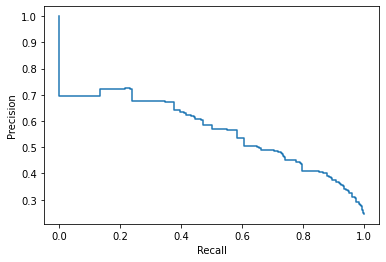

In [17]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [18]:
print(len(predictions))

14653


In [19]:
#you can see from when we loaded in the dataset that it is pretty large
#therefore a drop in 0.8% seem trival but it actually mean that misclassifactions are up by over 1,000 instances

In [20]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) #function that performs the reweighting for us
train = RW.fit_transform(OG_dataset_train) #change instance weights to the new ones
weights = train.instance_weights #saving ours weights to a variable to use below

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation) #cross validation with new weights
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation) #predictions with new weights
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict1, key=my_dict1.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))

print( "The model with the best fairness has a C value of: ", fair_key)

C value = 100000  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 1000  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 10  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 1.0  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 0.01  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 0.0001  Accuracy: 0.789  Equality_of_Opportunity score: 0.005
C value = 1e-06  Accuracy: 0.786  Equality_of_Opportunity score: 0.010
C value = 1e-08  Accuracy: 0.786  Equality_of_Opportunity score: 0.010
The model with the highest accuracy has a C value of:  0.0001
The model with the best fairness has a C value of:  100000


In [21]:
Model_3 = find_best_accuracy
Model_4 = fair_key

In [22]:
print("C value = ", Model_3)
Model = LogisticRegression(C=Model_3, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.0001
Accuracy 0.7911007984713028
Equality_of_Opportunity score: -0.003


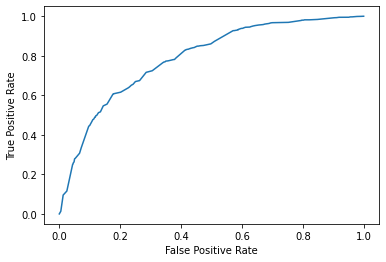

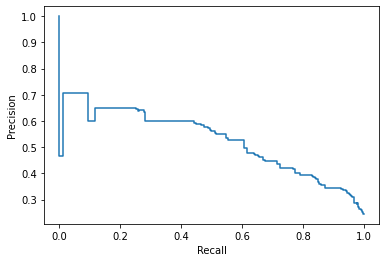

In [23]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [24]:
from sklearn.metrics import log_loss

In [25]:
print("C value = ", Model_4)
Model = LogisticRegression(C=Model_4, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.7886439636934416
Equality_of_Opportunity score: 0.015


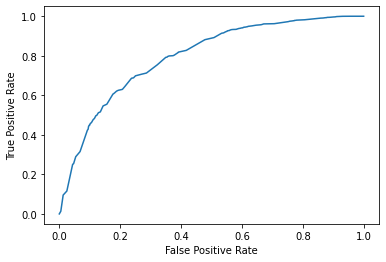

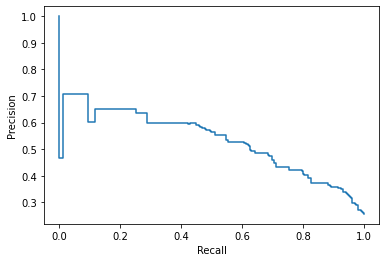

In [26]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [27]:
#TASK 3 before reweighting 

In [28]:
my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []
value= 0

my_dict3 = {}
BIC_scores =[]

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation)

  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

  proba = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation, method='predict_proba') #obtaining prediction probabilities as opposed to noraml predictions
  my_log_loss = log_loss(OG_dataset_train.labels, proba) #function to calculate the log_loss
  log_liklihood = my_log_loss * -1 #log_likihood is inverse of log_loss
  BIC= -2 * log_liklihood + np.log(X_train.shape[0]) * X_train.shape[1] #applied the BIC formula to my models
  BIC_scores.append(BIC) #stored in a list

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

for i in range(len(C_Values)):
    my_dict3[C_Values[i]] = BIC_scores[i]

for i in my_dict1:
  fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))
  highest_accuracy = max(my_dict1.values())
  accuracy_cireteria = highest_accuracy - 0.01

  fair_acc = 0
  for Cval, acc in my_dict1.items(): 
    if Cval == fair_key:
        fair_acc = fair_acc + acc

  if fair_acc > accuracy_cireteria:
    print("The model that has been selected as most fair + accurate is: ", fair_key)
    break
  else:
    del my_dict2[fair_key]

find_best_BIC = min(my_dict3, key=my_dict3.get) #selected lowest BIC score as this is supposed to be optimal 

print( "The model selected using bayes information theroy: ", find_best_BIC)

C value = 100000  Accuracy: 0.804  Equality_of_Opportunity score: -0.452
C value = 1000  Accuracy: 0.804  Equality_of_Opportunity score: -0.452
C value = 10  Accuracy: 0.804  Equality_of_Opportunity score: -0.452
C value = 1.0  Accuracy: 0.804  Equality_of_Opportunity score: -0.452
C value = 0.01  Accuracy: 0.805  Equality_of_Opportunity score: -0.449
C value = 0.0001  Accuracy: 0.798  Equality_of_Opportunity score: -0.240
C value = 1e-06  Accuracy: 0.796  Equality_of_Opportunity score: -0.231
C value = 1e-08  Accuracy: 0.796  Equality_of_Opportunity score: -0.224
The model that has been selected as most fair + accurate is:  1e-08
The model selected using bayes information theroy:  1.0


In [29]:
Model_5 = fair_key
Model_5_cond = find_best_BIC

In [30]:
print("C value = ", Model_5)
Model = LogisticRegression(C=Model_5, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1e-08
Accuracy 0.7963556950795059
Equality_of_Opportunity score: -0.231


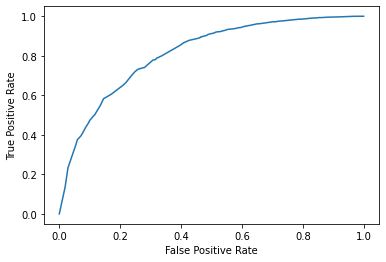

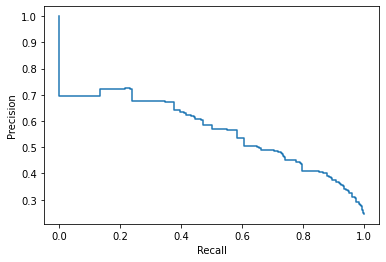

In [31]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [32]:
print("C value = ", Model_5_cond)
Model = LogisticRegression(C=Model_5_cond, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1.0
Accuracy 0.8027025182556473
Equality_of_Opportunity score: -0.451


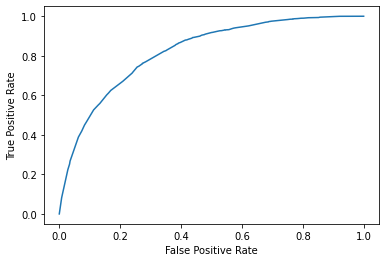

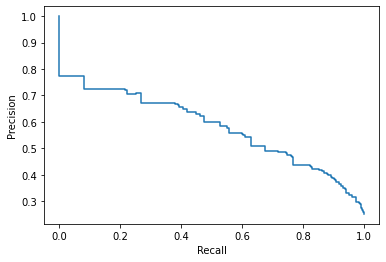

In [33]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [34]:
#TASK3 - after reweighting

In [35]:
my_dict1 = {}
my_dict2 = {}
my_dict3 = {}
accuracy = []
fairness = []
BIC_scores = []


RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train = RW.fit_transform(OG_dataset_train)
weights = train.instance_weights

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation)
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

  proba = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation, method='predict_proba')
  my_log_loss = log_loss(OG_dataset_train.labels, proba) 
  log_liklihood = my_log_loss * -1
  BIC= -2 * log_liklihood + np.log(X_train.shape[0]) * X_train.shape[1] 
  BIC_scores.append(BIC) 

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

for i in range(len(C_Values)):
    my_dict3[C_Values[i]] = BIC_scores[i]

for i in my_dict1:
  fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))
  highest_accuracy = max(my_dict1.values())
  accuracy_cireteria = highest_accuracy - 0.01

  fair_acc = 0
  for Cval, acc in my_dict1.items(): 
    if Cval == fair_key:
        fair_acc = fair_acc + acc

  if fair_acc > accuracy_cireteria:
    print("The model that has been selected as most fair + accurate is: ", fair_key)
    break
  else:
    del my_dict2[fair_key]

print(my_dict3)
find_best_BIC = min(my_dict3, key=my_dict3.get)

print( "The model selected using bayes information theroy: ", find_best_BIC)

C value = 100000  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 1000  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 10  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 1.0  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 0.01  Accuracy: 0.789  Equality_of_Opportunity score: 0.001
C value = 0.0001  Accuracy: 0.789  Equality_of_Opportunity score: 0.005
C value = 1e-06  Accuracy: 0.786  Equality_of_Opportunity score: 0.010
C value = 1e-08  Accuracy: 0.786  Equality_of_Opportunity score: 0.010
The model that has been selected as most fair + accurate is:  100000
{100000: 188.75338439287228, 1000: 188.75338437789443, 10: 188.75338293993843, 1.0: 188.7533742399374, 0.01: 188.75510950121884, 0.0001: 188.99399261699295, 1e-06: 189.2932966321671, 1e-08: 189.3000910821789}
The model selected using bayes information theroy:  1.0


In [36]:
Model_6 = fair_key
Model_6_cond = find_best_BIC

In [37]:
print("C value = ", Model_6)
Model = LogisticRegression(C=Model_6, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.7886439636934416
Equality_of_Opportunity score: 0.015


In [38]:
print("C value = ", Model_6_cond)
Model = LogisticRegression(C=Model_6_cond, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1.0
Accuracy 0.7886439636934416
Equality_of_Opportunity score: 0.015


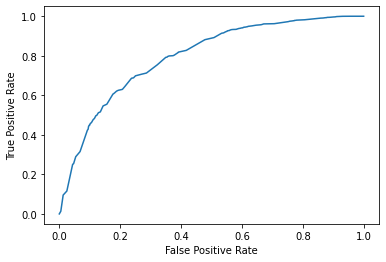

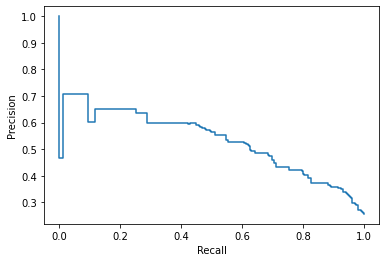

In [39]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

NOW ONTO THE GERMAN DATASET

In [40]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [41]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

--2022-05-12 16:15:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K   296KB/s    in 0.3s    

2022-05-12 16:15:06 (296 KB/s) - ‘german.data.1’ saved [79793/79793]



In [101]:
from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german

np.random.seed(4)

In [102]:
OG_dataset = load_preproc_data_german(['age']) #setting the protected attribute to age

OG_dataset_train, OG_dataset_test = OG_dataset.split([0.7], shuffle=True) 

privileged_groups2 = [{'age': 1}] #Over 25
unprivileged_groups2 = [{'age': 0}] #Under 25

#Normalise all the data (as per the lab class)
scale = StandardScaler()
X_train = scale.fit_transform(OG_dataset_train.features) #scales each feature/variable to unit variance
y_train = OG_dataset_train.labels.ravel() #Flattens array

X_test = scale.transform(OG_dataset_test.features) 
y_test = OG_dataset_test.labels.ravel()

Text(0.5, 0, 'Young                                             Old')

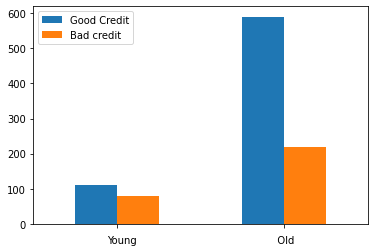

In [44]:
df = pd.DataFrame( OG_dataset.features , columns= OG_dataset.feature_names) 
df = df.assign(labels=OG_dataset.labels)

crosstab = pd.crosstab(df['age'], df['labels'])

ax = crosstab.plot(kind='bar')
ax.legend(["Good Credit", "Bad credit"])
ax.xaxis.set_ticklabels([]) 
ax.set_xlabel("Young                                             Old")

In [103]:
Cross_Validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
Model = LogisticRegression(solver='liblinear', random_state=1)

Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
print('Accuracy: %.3f  Standard deviation: %.3f' % (mean(Scores), std(Scores)))

Accuracy: 0.714  Standard deviation: 0.012


In [104]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
accuracy = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)))
  accuracy.append(mean(Scores))

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict, key=my_dict.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

C value = 100000  Accuracy: 0.714
C value = 1000  Accuracy: 0.714
C value = 10  Accuracy: 0.714
C value = 1.0  Accuracy: 0.714
C value = 0.01  Accuracy: 0.720
C value = 0.0001  Accuracy: 0.660
C value = 1e-06  Accuracy: 0.660
C value = 1e-08  Accuracy: 0.660
The model with the highest accuracy has a C value of:  0.01


In [105]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
fairness = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation)

  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  print("C value = " +  str(i) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)
  fairness.append(Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict.items(), key=lambda x: abs(value - x[1]))

print( "The model with the highest fairness has a C value of: ", fair_key)

C value = 100000  Equality_of_Opportunity score: -0.300
C value = 1000  Equality_of_Opportunity score: -0.300
C value = 10  Equality_of_Opportunity score: -0.300
C value = 1.0  Equality_of_Opportunity score: -0.300
C value = 0.01  Equality_of_Opportunity score: -0.313
C value = 0.0001  Equality_of_Opportunity score: -0.239
C value = 1e-06  Equality_of_Opportunity score: -0.239
C value = 1e-08  Equality_of_Opportunity score: -0.239
The model with the highest fairness has a C value of:  0.0001


In [106]:
Model_1 = find_best_accuracy
Model_2 = fair_key

In [107]:
print("C value = ", Model_1)
Model = LogisticRegression(C=Model_1, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.01
Accuracy 0.67
Equality_of_Opportunity score: -0.503


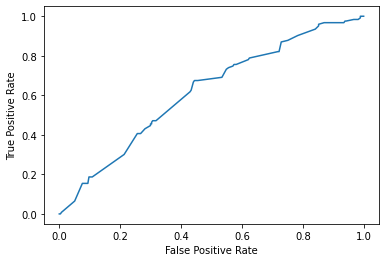

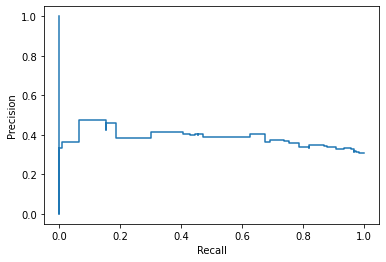

In [50]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [108]:
print("C value = ", Model_2)
Model = LogisticRegression(C=Model_2, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.0001
Accuracy 0.6333333333333333
Equality_of_Opportunity score: -0.408


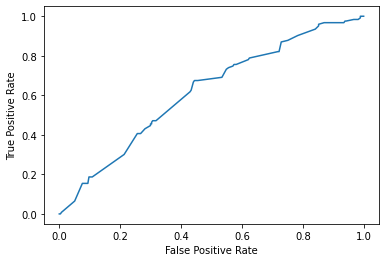

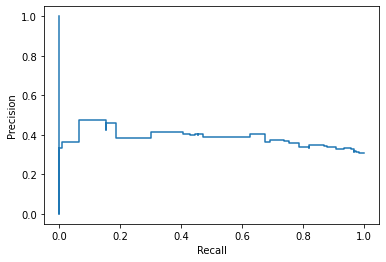

In [52]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [53]:
print(len(predictions))

400


In [54]:
#clearly there is some inherent difference in the test set when it comes to fairness as it's lots higher!

In [55]:
my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []

RW = Reweighing(unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
train = RW.fit_transform(OG_dataset_train)
weights = train.instance_weights

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation)
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict1, key=my_dict1.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))

print( "The model with the best fairness has a C value of: ", fair_key)

C value = 100000  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 1000  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 10  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 1.0  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 0.01  Accuracy: 0.682  Equality_of_Opportunity score: 0.030
C value = 0.0001  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
C value = 1e-06  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
C value = 1e-08  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
The model with the highest accuracy has a C value of:  100000
The model with the best fairness has a C value of:  100000


In [56]:
Model_3 = find_best_accuracy
Model_4 = fair_key

In [57]:
print("C value = ", Model_3)
Model = LogisticRegression(C=Model_3, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.6775
Equality_of_Opportunity score: -0.024


In [58]:
print("C value = ", Model_4)
Model = LogisticRegression(C=Model_4, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.6775
Equality_of_Opportunity score: -0.024


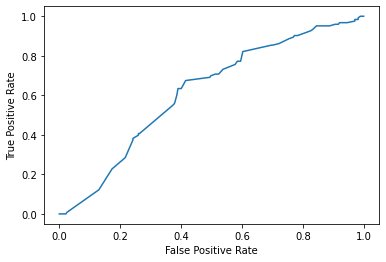

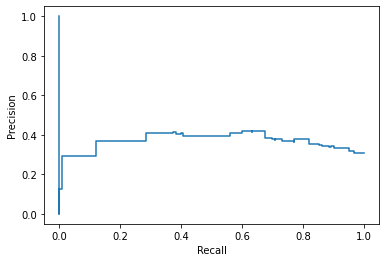

In [59]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [60]:
#TASK 3 - before reweighting

In [61]:
my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []
value= 0

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation)

  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

  proba = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation, method='predict_proba')
  my_log_loss = log_loss(OG_dataset_train.labels, proba) 
  log_liklihood = my_log_loss * -1
  BIC= -2 * log_liklihood + np.log(X_train.shape[0]) * X_train.shape[1] 
  BIC_scores.append(BIC) 

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

for i in my_dict1:
  fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))
  highest_accuracy = max(my_dict1.values())
  accuracy_cireteria = highest_accuracy - 0.03

  fair_acc = 0
  for Cval, acc in my_dict1.items(): 
    if Cval == fair_key:
        fair_acc = fair_acc + acc

  if fair_acc > accuracy_cireteria:
    print("The model that has been selected as most fair + accurate is: ", fair_key)
    break
  else:
    del my_dict2[fair_key]

for i in range(len(C_Values)):
    my_dict3[C_Values[i]] = BIC_scores[i]

find_best_BIC = min(my_dict3, key=my_dict3.get)

print( "The model selected using bayes information theroy: ", find_best_BIC)

C value = 100000  Accuracy: 0.728  Equality_of_Opportunity score: -0.307
C value = 1000  Accuracy: 0.728  Equality_of_Opportunity score: -0.307
C value = 10  Accuracy: 0.728  Equality_of_Opportunity score: -0.307
C value = 1.0  Accuracy: 0.728  Equality_of_Opportunity score: -0.307
C value = 0.01  Accuracy: 0.722  Equality_of_Opportunity score: -0.368
C value = 0.0001  Accuracy: 0.665  Equality_of_Opportunity score: -0.317
C value = 1e-06  Accuracy: 0.665  Equality_of_Opportunity score: -0.317
C value = 1e-08  Accuracy: 0.665  Equality_of_Opportunity score: -0.317
The model that has been selected as most fair + accurate is:  100000
The model selected using bayes information theroy:  1.0


In [62]:
#This decision makes sense to me as the improvement in fairness is quite small and i don't think justifies a 5% drop in accuracy

In [63]:
Model_5 = fair_key
Model_5_cond = find_best_BIC

print("C value = ", Model_5)
Model = LogisticRegression(C=Model_5, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.675
Equality_of_Opportunity score: -0.456


In [64]:
print("C value = ", Model_5_cond)
Model = LogisticRegression(C=Model_5_cond, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1.0
Accuracy 0.675
Equality_of_Opportunity score: -0.456


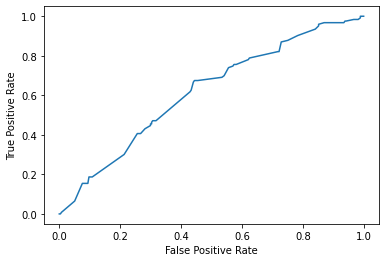

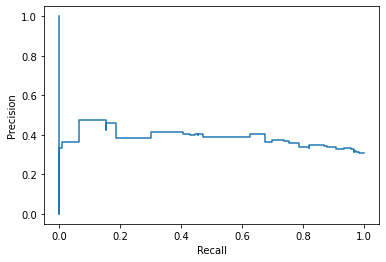

In [65]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [66]:
my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []

RW = Reweighing(unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
train = RW.fit_transform(OG_dataset_train)
weights = train.instance_weights

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation)
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

  proba = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation, method='predict_proba')
  my_log_loss = log_loss(OG_dataset_train.labels, proba) 
  log_liklihood = my_log_loss * -1
  BIC= -2 * log_liklihood + np.log(X_train.shape[0]) * X_train.shape[1] 
  BIC_scores.append(BIC) 

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

for i in my_dict1:
  fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))
  highest_accuracy = max(my_dict1.values())
  accuracy_cireteria = highest_accuracy - 0.03

  fair_acc = 0
  for Cval, acc in my_dict1.items(): 
    if Cval == fair_key:
        fair_acc = fair_acc + acc

  if fair_acc > accuracy_cireteria:
    print("The model that has been selected as most fair + accurate is: ", fair_key)
    break
  else:
    del my_dict2[fair_key]

find_best_BIC = min(my_dict3, key=my_dict3.get)

print( "The model selected using bayes information theroy: ", find_best_BIC)

C value = 100000  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 1000  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 10  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 1.0  Accuracy: 0.718  Equality_of_Opportunity score: 0.011
C value = 0.01  Accuracy: 0.682  Equality_of_Opportunity score: 0.030
C value = 0.0001  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
C value = 1e-06  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
C value = 1e-08  Accuracy: 0.678  Equality_of_Opportunity score: -0.090
The model that has been selected as most fair + accurate is:  100000
The model selected using bayes information theroy:  1.0


In [67]:
Model_6 = fair_key
Model_6_cond = find_best_BIC

print("C value = ", Model_6)
Model = LogisticRegression(C=Model_6, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.6775
Equality_of_Opportunity score: -0.024


In [68]:
print("C value = ", Model_6_cond)
Model = LogisticRegression(C=Model_6_cond, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1.0
Accuracy 0.6775
Equality_of_Opportunity score: -0.024


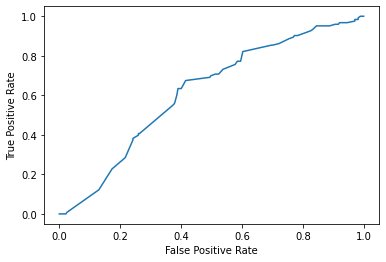

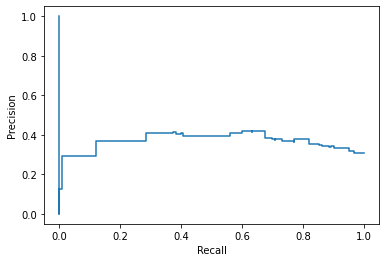

In [69]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [70]:
#END

EXTRA STUFF

In [71]:
#Fairness through unawareness 
#Not using the protected attributes in training a model at all
#Did this on a seperate notebook 